In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
# Visualzation 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
# Feature selection
from sklearn.feature_selection import SelectKBest
# Models
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# For making poly models
from sklearn.preprocessing import PolynomialFeatures
# Model selection and Selection of Model Parameters
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     RandomizedSearchCV, GridSearchCV,
                                     ShuffleSplit)
from sklearn.metrics import (recall_score, confusion_matrix, f1_score,
                             accuracy_score, precision_score, roc_curve,
                             roc_auc_score)
# Сlass balancing
from imblearn.over_sampling import SMOTE
# Statistics 
import scipy.stats as stats
# Limit on displaying maximum 50 columns of DataFrame
pd.options.display.max_columns = 50

# [Dataset](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset)

# **Table of Contents** 
* **[EDA](#EDA)**
    * [Information about data](#DATAINFO)
    * [Missing values](#Missing_values)
    * [Initial data preprocessing](#Preprocessing)
    * [Fire researching](#Fire)
    * [Corection of labels](#Correction)
    * [Label difference](#Label_Dif)
    * [Outliers detection](#OutliersDetect)
    * [Correlation Analysis](#CorrelationAnalysis)


* **[Feature Selection](#FeatureSelect)**
    * [PCA](#PCA)
    * [Select K Best features method](#SelectKBest)
    
* **[Modeling](#Modeling)**
    * [Spliting data](#DataSplit)
    * [LinearSVC](#LinearSVC) 
    * [Result of Linear SVC](#ResultSVC) 
        
    * [Random Forest Classifier with Randomized Search](#RFC)
    * [Result of Random Forest](#ResultRF)
        
    * [XGBoost Classifier](#XGBoost)
    * [Result of XGBoost Classifier](#ResultXGB)
    * [ROC curves](#ROC)
      

# [EDA](#EDA)

In [2]:
data = pd.read_csv("../input/smoke-detection-dataset/smoke_detection_iot.csv")
data.head()

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
0           0  1654733331          20.000        57.36          0        400   
1           1  1654733332          20.015        56.67          0        400   
2           2  1654733333          20.029        55.96          0        400   
3           3  1654733334          20.044        55.28          0        400   
4           4  1654733335          20.059        54.69          0        400   

   Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  CNT  \
0   12306        18520        939.735    0.0    0.0    0.0    0.0    0.0    0   
1   12345        18651        939.744    0.0    0.0    0.0    0.0    0.0    1   
2   12374        18764        939.738    0.0    0.0    0.0    0.0    0.0    2   
3   12390        18849        939.736    0.0    0.0    0.0    0.0    0.0    3   
4   12403        18921        939.744    0.0    0.0    0.0    0.0    0.0    4   

   Fire Alarm  
0           0  
1           0  
2           0  
3           0  
4           0

<h3 id="DATAINFO">Information about data</h3>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


**Using the info function, we can pull the following information from our dataset:**
* We have 16 numerical variables
* We haven't missing values for the Income variable

<h3 id="Missing_values">Missing values</h3>

In [4]:
# Select columns which 1 and more missing values
missing_values = data.isna().sum() > 0
# If dataframe hasn't missing values 
if len(data.isna().sum()[missing_values]) == 0:
    print("Dataset doesn't include missing values")
# Plot bar otherwise
else: 
    data.isna().sum()[missing_values].plot(kind="barh")

Dataset doesn't include missing values


<h3 id="Preprocessing">Initial data preprocessing</h3>

In [5]:
# Copy of our dataframe for manipulations
copy_df = data.copy()

# Drop Unnamed: 0 column because it's number of row
copy_df = copy_df.drop("Unnamed: 0", axis=1)
# Correct time format
copy_df["UTC"] = pd.to_datetime(copy_df["UTC"], unit='s')
# Separate year, da in feature

# Look on the description of the data
copy_df.describe().drop("Fire Alarm", axis=1).drop("count")

Temperature[C]  Humidity[%]     TVOC[ppb]     eCO2[ppm]        Raw H2  \
mean       15.970424    48.539499   1942.057528    670.021044  12942.453936   
std        14.359576     8.865367   7811.589055   1905.885439    272.464305   
min       -22.010000    10.740000      0.000000    400.000000  10668.000000   
25%        10.994250    47.530000    130.000000    400.000000  12830.000000   
50%        20.130000    50.150000    981.000000    400.000000  12924.000000   
75%        25.409500    53.240000   1189.000000    438.000000  13109.000000   
max        59.930000    75.200000  60000.000000  60000.000000  13803.000000   

       Raw Ethanol  Pressure[hPa]         PM1.0         PM2.5         NC0.5  \
mean  19754.257912     938.627649    100.594309    184.467770    491.463608   
std     609.513156       1.331344    922.524245   1976.305615   4265.661251   
min   15317.000000     930.852000      0.000000      0.000000      0.000000   
25%   19435.000000     938.700000      1.280000      1.340000      8.820000   
50%   19501.000000     938.816000      1.810000      1.880000     12.450000   
75%   20078.000000     939.418000      2.090000      2.180000     14.420000   
max   21410.000000     939.861000  14333.690000  45432.260000  61482.030000   

             NC1.0         NC2.5           CNT  
mean    203.586487     80.049042  10511.386157  
std    2214.738556   1083.383189   7597.870997  
min       0.000000      0.000000      0.000000  
25%       1.384000      0.033000   3625.250000  
50%       1.943000      0.044000   9336.000000  
75%       2.249000      0.051000  17164.750000  
max   51914.680000  30026.438000  24993.000000

<h3 id="Fire">Fire researching</h3>

In [6]:
# Array which will contain tuples: (start area index, finish area index)
stop_index = []
# Start index
start = 0
# Colors. Green - non-fire / Red - fire 
colors = ["green", "red"] * 6
# Find area when fire changed on non-Fire
for index in range(len(copy_df) - 1):
    # If next label isn't equal
    if copy_df["Fire Alarm"][index] != copy_df["Fire Alarm"][index+1]:
        finish = index + 1       
        # Appending a tuple in list
        stop_index.append(tuple([start, finish]))
        start = finish
# Add finish:len(copy_df) area
else: 
    stop_index.append(tuple([finish+1, copy_df.index.max()]))

# Checking durations
for area in enumerate(stop_index):
    print(f"Duration {area[0]+1} area[status: {copy_df.iloc[:, -1][area[1][0]]}]: {area[1][1] - area[1][0]}")

Duration 1 area[status: 0]: 3178
Duration 2 area[status: 1]: 21816
Duration 3 area[status: 0]: 3178
Duration 4 area[status: 1]: 21816
Duration 5 area[status: 0]: 33
Duration 6 area[status: 1]: 1121
Duration 7 area[status: 0]: 3
Duration 8 area[status: 1]: 2
Duration 9 area[status: 0]: 5742
Duration 10 area[status: 1]: 2
Duration 11 area[status: 0]: 5737


##### We can see that: 
* Areas 7, 8, 10 are like failures. We should change their labels
* Dataframe includes 3 fires. We will include duration of area in dataframe later. It can help in classification
* Areas 5, 7, 8 will get fire-status because it's looks like hardware failure after fire

<h3 id="Correction">Corection of labels</h3>

In [7]:
duration_changer = [4, 6, 7, 9]
for sector in duration_changer:    
    if sector == 9:
        copy_df["Fire Alarm"][stop_index[sector][0]:stop_index[sector][1]] = 0
    else: 
        copy_df["Fire Alarm"][stop_index[sector][0]:stop_index[sector][1]] = 1

In [8]:
px.line(copy_df["Fire Alarm"], title="Fire Alarms in time", width=800)

<h3 id="Label_Dif">Label difference</h3>

In [9]:
grouped_df = copy_df.drop("UTC", axis=1).groupby("Fire Alarm").agg("mean").reset_index()

px.bar(grouped_df, y=['TVOC[ppb]', 'Raw H2', 'Raw Ethanol', 'CNT'], barmode="group",
      width=800, labels={"index": "label"}, 
       title="Barplot for 'TVOC[ppb]', 'Raw H2', 'Raw Ethanol', 'CNT'")

In [10]:
px.bar(grouped_df, y=['Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Pressure[hPa]', 'PM1.0',
                      'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5'], barmode="group",
      width=800, labels={"index": "label"}, 
       title="Barplot for 'TVOC[ppb]', 'Raw H2', 'Raw Ethanol', 'CNT'")

<h3 id="OutliersDetect">Outliers detection</h3>

In [11]:
for col in copy_df.columns.drop(["UTC", "Fire Alarm"]):
    fig = px.violin(copy_df, y=copy_df[col], box=True, color="Fire Alarm", width=600, points=False,
                    title=f"{col.title()}")
    fig.show()

In [12]:
for col in copy_df.columns.drop(["UTC", "Fire Alarm"]):
    IQR = 1.5 * (copy_df[col].quantile(0.75) - copy_df[col].quantile(0.25))
    print(f"{col}:\n Upper border: {copy_df[col].loc[copy_df[col] > copy_df[col].quantile(0.75) + IQR].count()}\n"
          f" Lower border: {copy_df[col].loc[copy_df[col] < copy_df[col].quantile(0.25) - IQR].count()}\n")

Temperature[C]:
 Upper border: 1047
 Lower border: 2861

Humidity[%]:
 Upper border: 730
 Lower border: 4353

TVOC[ppb]:
 Upper border: 2463
 Lower border: 0

eCO2[ppm]:
 Upper border: 12076
 Lower border: 0

Raw H2:
 Upper border: 757
 Lower border: 1196

Raw Ethanol:
 Upper border: 957
 Lower border: 994

Pressure[hPa]:
 Upper border: 0
 Lower border: 12632

PM1.0:
 Upper border: 1586
 Lower border: 396

PM2.5:
 Upper border: 1592
 Lower border: 248

NC0.5:
 Upper border: 1586
 Lower border: 534

NC1.0:
 Upper border: 1596
 Lower border: 262

NC2.5:
 Upper border: 1918
 Lower border: 1756

CNT:
 Upper border: 0
 Lower border: 0



<h3 id="CorrelationAnalysis">Correlation analysis</h3>

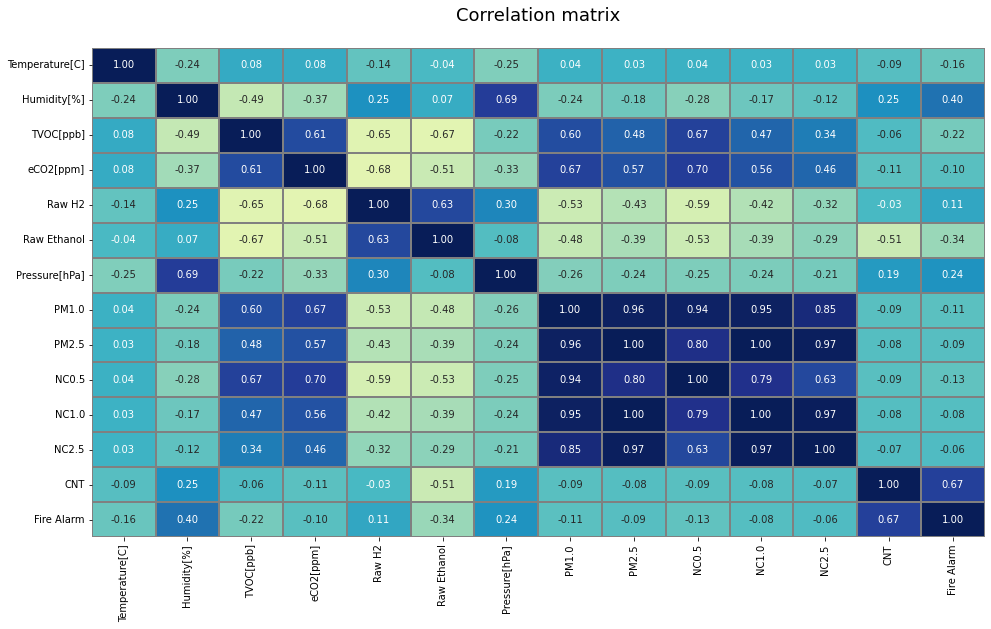

In [13]:
# Figure size
plt.subplots(figsize=(16, 9))
# Correlation matrix
sns.heatmap(copy_df.drop("UTC", axis=1).corr(),
            fmt=".2f", annot=True, cmap="YlGnBu", center=0,
           linewidths=0.01, linecolor='gray', cbar=False)
# Set a title for figure
plt.title("Correlation matrix\n", fontsize=18);

**We see a very strong correlation between:** 
* Pressre and Humidity
* eCO2 and TVOC 
* PM1.0 and eCO2 / PM1.0 and TVOC 
* PM 2.5 and eCO2 / PM 2.5 and TVOC  
* NC0.5 and eCO2 / NC0.5 and TVOC 
* NC1.0 and eCO2 / NC1.0 and TVOC  
* NC2.5 and eCO2 / NC2.5 and TVOC
    
* We can remove PM* features and replace them NC(concentration features)

In [14]:
# Dropping PM* features 
copy_df = copy_df.drop(["PM1.0", "PM2.5", "UTC", "NC2.5"], axis=1)

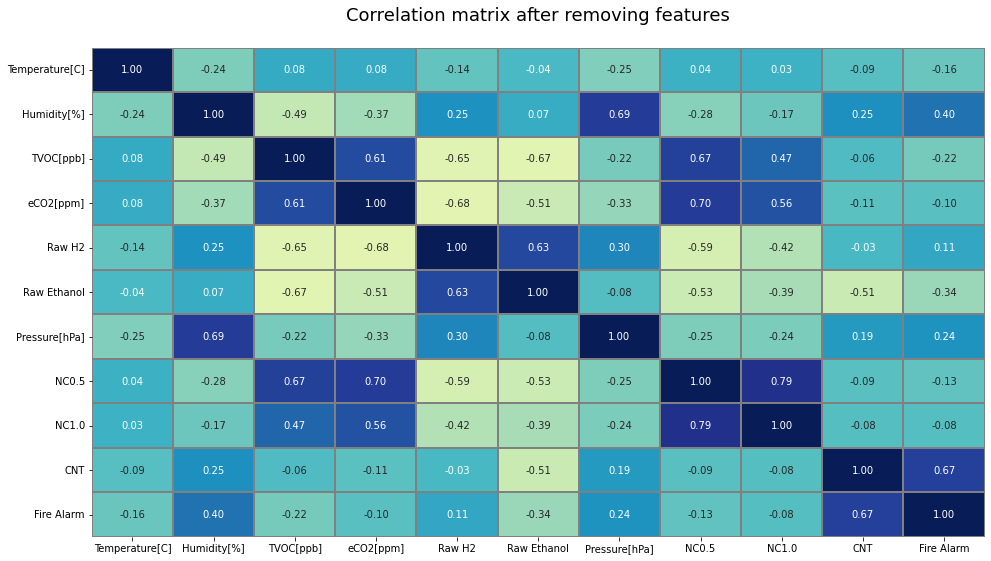

In [15]:
# Figure size
plt.subplots(figsize=(16, 9))
# Correlation matrix
sns.heatmap(copy_df.corr(),
            fmt=".2f", annot=True, cmap="YlGnBu", center=0,
            linewidths=0.01, linecolor='gray', cbar=False)
# Set a title for figure
plt.title("Correlation matrix after removing features\n", fontsize=18);

We can see a strong negative correlation between features but we won't drop them because: 
* TVOC is Volatile Organic Compounds so this feature will have a positive correlation with NC0.5 and NC1.0 
* The more humidity the more pressure

# [Feature Selection](#FeatureSelect)

<h3 id="PCA">PCA</h3>

We can use PCA method for getting k of most import features

In [16]:
# Predictors
X = copy_df.drop("Fire Alarm", axis=1)
# Labels
y = copy_df["Fire Alarm"]

In [17]:
pca = PCA(n_components=0.95) # if type(n_components) = float then method returns number of features sum of importance which give float value 
pca.fit(X, y)
print(f"We need {len(pca.explained_variance_ratio_)} components for getting 95% variance")

We need 3 components for getting 95% variance


#### We can look on features importances with random forest


In [18]:
rf = RandomForestClassifier()
rf.fit(X, y)
# Feature Importances array for plot
feature_importance = np.flip(np.sort(rf.feature_importances_)).cumsum()
feature_importance = np.insert(feature_importance, 0, 0.0)

# Plotting 
fig = px.line(x=range(len(feature_importance)), y=feature_importance, width=800,
              title="Feature importances with Random Forest Classifier",
              labels={'x': 'Number of features', 
                      'y': 'Feature importances'})
# Tick params for x axis
fig.update_layout(xaxis=dict(
                             tickmode = 'linear',
                             dtick = 1
                            )
                 )

#### We will use 5 features

<h3 id="SelectKBest">Select K Best features method</h3>

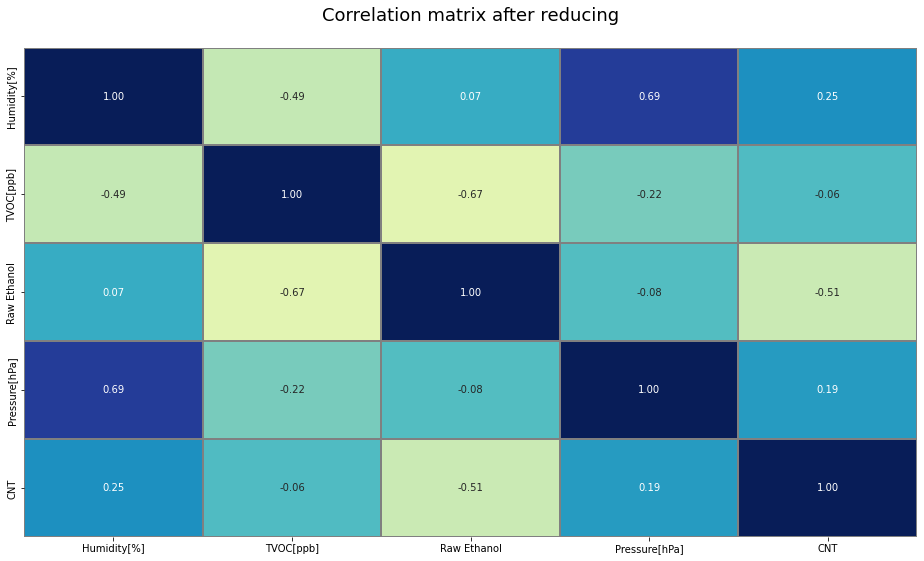

In [19]:
# Scaling our data
X_scaling = StandardScaler().fit_transform(X)
# Select 5 the most import features
select_k_best = SelectKBest(k=5)
X_reduced = select_k_best.fit_transform(X_scaling, y)
# Names of the most important features
number_columns = select_k_best.get_feature_names_out()

# Getting names of this features
name_columns = copy_df.columns[[int(x.replace('x', '')) for x in number_columns]]

# Correlation matrix for reduced X
# Figure size
plt.subplots(figsize=(16, 9))
# Correlation matrix
sns.heatmap(copy_df[name_columns].corr(),
            fmt=".2f", annot=True, cmap="YlGnBu", center=0,
            linewidths=0.01, linecolor='gray', cbar=False)
# Set a title for figure
plt.title("Correlation matrix after reducing\n", fontsize=18);

# [Modeling](#Modeling)

<h3 id="DataSplit">Spliting data</h3>

In [20]:
# (X_tune, y_tune) will use for tuning params 
# (X_test, y_test) will use to test the effectiveness of the model
X_tune, X_test, y_tune, y_test = train_test_split(X_reduced, y, test_size=0.5)

<h3 id="LinearSVC">LinearSVC</h3>

In [21]:
# Linear svc model
linear_svc = LinearSVC()
# Params for tuning
grid_params = {
    'C': [10 ** x for x in range(-4, 3)]
}
# Grid Search method
grid_search = GridSearchCV(linear_svc, param_grid=grid_params)
grid_search.fit(X_tune, y_tune)
# Predict values for confusion matrix
y_pred_lin_svc = grid_search.best_estimator_.predict(X_test)

<h3 id="ResultSVC">Result of Linear SVC</h3>


#### We don't use accuracy score because labels are not balanced

 Presion score: 0.990
 Recall score: 0.995
 F1 score: 0.993


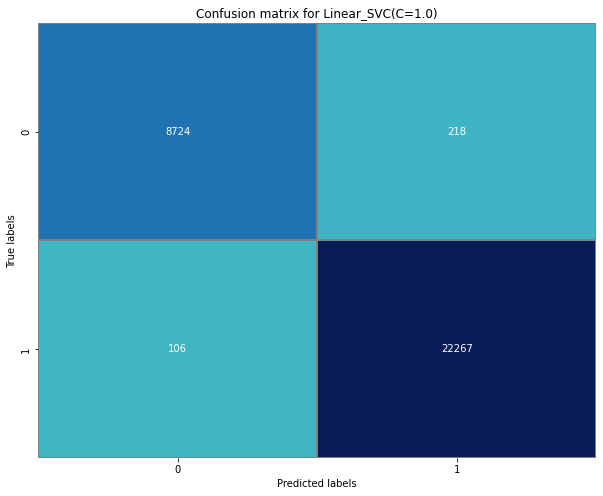

In [22]:
print(f" Presion score: {precision_score(y_test, y_pred_lin_svc):.3f}\n"
      f" Recall score: {recall_score(y_test, y_pred_lin_svc):.3f}\n"
      f" F1 score: {f1_score(y_test, y_pred_lin_svc):.3f}")
# Confusion Matrix
plt.subplots(figsize=(10, 8))
conf_matrix = sns.heatmap(confusion_matrix(y_test, y_pred_lin_svc), 
                          fmt="d", annot=True, cmap="YlGnBu", center=0,
                          linewidths=0.01, linecolor='gray', cbar=False)
conf_matrix.set(ylabel="True labels", xlabel="Predicted labels",
                title="Confusion matrix for Linear_SVC(C=1.0)");

<h3 id="RFC">Random Forest Classifier with Randomized Search</h3>

#### We use Randomized search because it has near result with grid search but faster. We will increase n_estimators after getting the best values for params

In [23]:
random_params_rf = {
    'max_depth': [None, 3, 4, 5, 6, 7, 8], 
    'max_features': [1, 2, 3, 4, 5], 
    'n_estimators': [250], 
} 
# Randomized search for Random Forest
random_search_rf = RandomizedSearchCV(RandomForestClassifier(), random_params_rf,
                                     n_jobs=-1, n_iter=15)
random_search_rf.fit(X_tune, y_tune)
# Predict values with the best rf estimator 
y_pred_rf = random_search_rf.best_estimator_.predict(X_test)
# Print the best hyper parameters 
random_search_rf.best_params_

{'n_estimators': 250, 'max_features': 1, 'max_depth': 8}

In [24]:
tuned_rf = RandomForestClassifier(n_estimators=1500, 
                                  max_features=1, 
                                  max_depth=6)
tuned_rf.fit(X_tune, y_tune)
y_pred_rf = tuned_rf.predict(X_test)

<h3 id="ResultRF">Result of Random Forest</h3>

 Presion score: 1.000
 Recall score: 1.000
 F1 score: 1.000


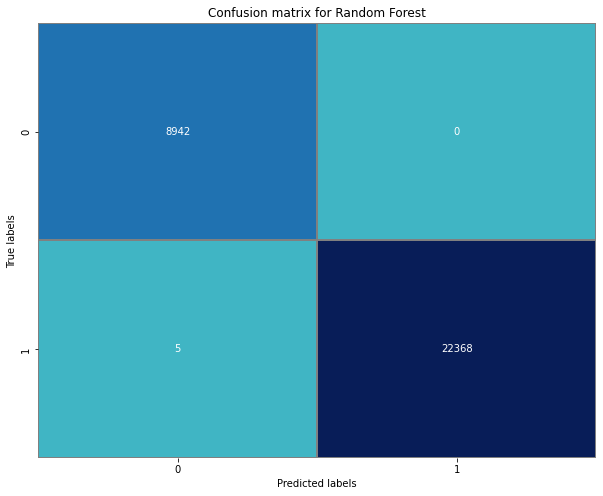

In [25]:
# Confusion Matrix
print(f" Presion score: {precision_score(y_test, y_pred_rf):.3f}\n"
      f" Recall score: {recall_score(y_test, y_pred_rf):.3f}\n"
      f" F1 score: {f1_score(y_test, y_pred_rf):.3f}")

plt.subplots(figsize=(10, 8))
conf_matrix = sns.heatmap(confusion_matrix(y_test, y_pred_rf), 
                          fmt="d", annot=True, cmap="YlGnBu", center=0,
                          linewidths=0.01, linecolor='gray', cbar=False)
# Set Xlabel and Ylabel
conf_matrix.set(ylabel="True labels", xlabel="Predicted labels",
                title="Confusion matrix for Random Forest");

<h3 id="XGBoost">XGBoost Classifier</h3>

In [26]:
# XGBoost params 
xgboost = XGBClassifier(learning_rate=0.01,
                        n_estimators=1500, 
                        reg_alpha=0.1, 
                        reg_lambda=0.1, 
                        colsample_bytree=0.9,
                        objective='binary:logistic',
                        nthread=4,
                        max_depth=8,
                        min_child_weight=1)
# Train alghoritm
xgboost.fit(X_tune, y_tune)
# Predict values
y_pred_xgboost = xgboost.predict(X_test)

<h3 id="ResultXGB">Result of XGBoost Classifier</h3>

 Presion score: 1.000
 Recall score: 1.000
 F1 score: 1.000


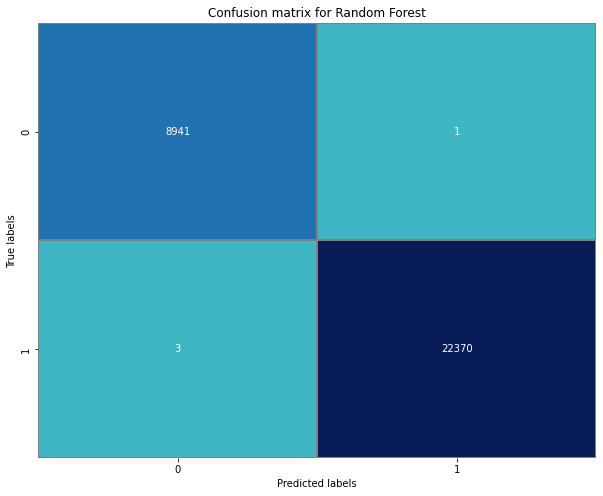

In [27]:
# Confusion Matrix
print(f" Presion score: {precision_score(y_test, y_pred_xgboost):.3f}\n"
      f" Recall score: {recall_score(y_test, y_pred_xgboost):.3f}\n"
      f" F1 score: {f1_score(y_test, y_pred_xgboost):.3f}")

plt.subplots(figsize=(10, 8))
conf_matrix = sns.heatmap(confusion_matrix(y_test, y_pred_xgboost), 
                          fmt="d", annot=True, cmap="YlGnBu", center=0,
                          linewidths=0.01, linecolor='gray', cbar=False)
# Set Xlabel and Ylabel
conf_matrix.set(ylabel="True labels", xlabel="Predicted labels",
                title="Confusion matrix for Random Forest");

<h3 id="ROC">ROC curves</h3>

In [28]:
# ROC-curves and AUC
# Linear SVC 
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_lin_svc)
svc_auc = round(roc_auc_score(y_test, y_pred_lin_svc), 3)

# Random Forest 
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
rf_auc = round(roc_auc_score(y_test, y_pred_rf), 3)

# XGBoost 
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgboost)
xgb_auc = round(roc_auc_score(y_test, y_pred_xgboost), 3)

<AxesSubplot:>

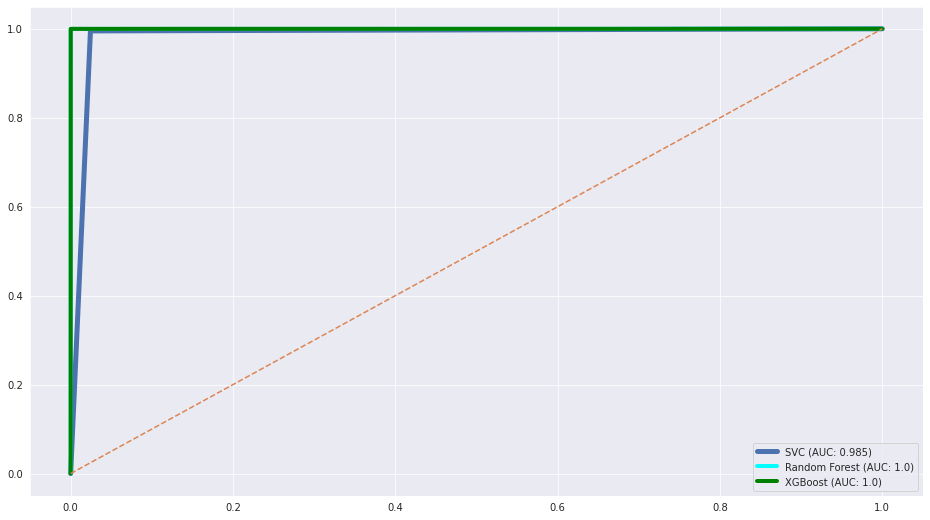

In [29]:
# Change figure size
sns.set_theme({"figure.figsize": (16, 9)})
# SVC ROC
plot = sns.lineplot(fpr_svc, tpr_svc, linewidth=5,
                    label=f"SVC (AUC: {svc_auc})")
# Random Forest ROC
plot.plot(fpr_rf, tpr_rf, linewidth=4, color='cyan', 
             label=f"Random Forest (AUC: {rf_auc})", )
# XGBoost ROC
sns.lineplot(fpr_xgb, tpr_xgb, linewidth=4, color='green', 
             label=f"XGBoost (AUC: {xgb_auc})", 
             ax=plot)
# Line of random guessing
sns.lineplot([0, 1], [0, 1], linestyle='--', ax=plot)